In [1]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state
from _lloyd_iter import calc_sums

In [48]:
class KKMeans():
    def __init__(self, n_clusters=8, init="random", n_init=1,
                 max_iter=300, tol=None, verbose=0,
                 random_state=None, algorithm="lloyd", kernel="linear", **kwds):
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.random_state = check_random_state(random_state)
        self.algorithm = algorithm
        self.kernel = kernel
        self.kwds = kwds
        self.labels = None
        return
    
    def p_kernel_wrapper(self, x, y=None):
        n_jobs = 1
        return np.ascontiguousarray(pairwise_kernels(x, y, n_jobs=n_jobs, metric=self.kernel, **self.kwds)) 
    
    def fit(self, data):
        self._check_data(data)
        
        if self.algorithm == "lloyd":
            self._lloyd(data)
        
    def _check_data(self, data):
        #TODO
        return
    
    def _lloyd(self, data):
        kernel_matrix = self.p_kernel_wrapper(data)
        self._init(data, kernel_matrix)
        inertia = 0
        for _ in range(self.max_iter):
            distances = np.tile(np.diag(kernel_matrix), (self.n_clusters, 1)).T
            self._lloyd_iter(kernel_matrix, distances)
            labels_new = np.argmin(distances, axis=1)
            inertia_new = np.amin(distances, axis=1).sum()
            if all(labels_new == self.labels) or abs(inertia - inertia_new) < self.tol:
                if self.verbose:
                    print("Converged at iteration:", _ + 1,
                          "Inertia:", inertia_new)
                break                
            if self.verbose:
                print("Iteration:", _ + 1,
                      "Inertia:", inertia_new)
            self.labels = labels_new
            inertia = inertia_new
    
    def _lloyd_iter(self, kernel_matrix, distances):
        element_sums, cluster_sums, magnitudes =\
            calc_sums(kernel_matrix, self.labels, self.n_clusters)
        
        for cluster in range(self.n_clusters):
            magn = magnitudes[cluster]
            el_sum = element_sums[:, cluster]
            cl_sum = cluster_sums[cluster]
            distances[:, cluster] += (cl_sum / magn**2
                                     -2 * el_sum / magn)
    
    def _init(self, data, kernel_matrix):
        if isinstance(self.init, (list, tuple, np.ndarray)):
            self._check_centroids() # TODO 
            self._assign_to_centroids(self.init, data)
            return
        
        elif self.init == "random":
            centroids = data[self.random_state.randint(0, len(data), self.n_clusters)]
            self._assign_to_centroids(centroids, data)
            return
        
        elif self.init == "truerandom":
            self.labels = self.random_state.randint(0, self.n_clusters, len(data))
            return
        
        elif self.init == "kmeans++":
            self._kmeanspp(data, kernel_matrix)
            return 
        
        raise Exception("Unknown initialisation method")
    
    def _check_centroids(self):
        if len(self.init) != self.n_clusters:
            raise Exception("The number of given centroids should match n_clusters") # TODO
        return

    def _assign_to_centroids(self, centroids, data):
        data_centr_kernel = self.p_kernel_wrapper(data, centroids)
        centr_distances = np.zeros((len(data), self.n_clusters))
        for cluster in range(self.n_clusters):
            centr_distances[:, cluster] = (-2 * data_centr_kernel[:, cluster]
                + self.p_kernel_wrapper([centroids[cluster]]))
        self.labels = np.argmin(centr_distances, axis = 1)
        return

    
    def _kmeanspp(self, data, kernel_matrix):
        
        centroids = np.zeros((self.n_clusters, len(data[0])))
        centr_distances = np.tile(np.diag(kernel_matrix), (self.n_clusters, 1)).T   
        for cluster in range(self.n_clusters):
            if cluster == 0:
                #random first center
                index = self.random_state.randint(len(data))
            else:
                max_dist_each = np.amin(centr_distances[:, :cluster + 1], axis = 1)
                max_dist_each[max_dist_each < 0] = 0
                probs = max_dist_each/max_dist_each.sum()
                index = self.random_state.choice(len(data), size = 1, p = probs)
            centroids[cluster] = data[index]
            cluster_term = self.p_kernel_wrapper([centroids[cluster]])
            data_term = self.p_kernel_wrapper(data, [centroids[cluster]])
            centr_distances[:, cluster] += (-2 * data_term + cluster_term).reshape(len(data),)    
        self.labels = np.argmin(centr_distances, axis = 1)
                
        return

In [49]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.cluster import KMeans

In [50]:
def visualize(data, labels):
    if len(data[0]) > 3:
        raise Exception("Dimensionality is too high for visualization")
    elif len(data[0]) == 1:
        plt.scatter(data, [0 for x in range(len(data))], c = labels)
    elif len(data[0]) == 2:
        plt.scatter(data[:,0], data[:,1], c = labels)
    elif len(data[0]) == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection = "3d")
        ax.scatter(data[:,0], data[:,1], data[:,2], c = labels)

In [54]:
x, labels, centers = make_blobs(10000, centers = 10, return_centers = True, random_state = 0, n_features = 3)

In [55]:
kkm = KKMeans(n_clusters = 10, verbose = True, init = "kmeans++", kernel = "linear", random_state = 0, tol = 1e-4)

Iteration: 1 Inertia: 52814.76157179794
Iteration: 2 Inertia: 52131.92020033645
Iteration: 3 Inertia: 52106.74223996597
Iteration: 4 Inertia: 52103.73758466322
Iteration: 5 Inertia: 52102.870126977374
Iteration: 6 Inertia: 52102.692144903696
Iteration: 7 Inertia: 52102.60354956066
Iteration: 8 Inertia: 52102.57440581743
Converged at iteration: 9 Inertia: 52102.570999099145


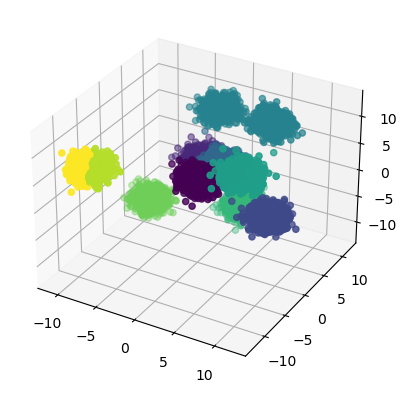

In [56]:
kkm.fit(x)
visualize(x, kkm.labels)